In [31]:
import numpy as np
from numpy.random import choice

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.func import hessian

import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

from scipy.integrate import odeint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install cmasher
import cmasher as cmr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 15.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load in data if saved
Burgers_data_np = np.load("/content/drive/MyDrive/Burgers_eq_data.pth.npy")
Burgers_data = torch.from_numpy(Burgers_data_np).type(torch.float32).to(device) # Convert to appropriate PyTorch tensor

In [32]:
# Create dataset for training.
# Please note we used code from this repository to generate our data:
# https://github.com/sachabinder/Burgers_equation_simulation/tree/main

# Number of PDE solutions
num_samples = 5000

np.random.seed(1)

# Spatial mesh
L_x = 1
dx = 0.005
N_x = int(L_x/dx + 1)
X = np.linspace(0,L_x,N_x)

# Temporal mesh
L_t = 1.0
dt = 0.005
N_t = int(L_t/dt + 1)
T = np.linspace(0,L_t,N_t)

k = 2*np.pi*np.fft.fftfreq(N_x, d = dx)

# Torch tensors to store data
u = torch.zeros(size=(N_x*num_samples,N_x))
v = torch.zeros(size=(N_x*num_samples,N_x))
t = torch.zeros(size=(N_x*num_samples,1))

uu = np.zeros(shape=(num_samples,N_x,N_t))

for num in range(num_samples):

  # Random initial condition
  alpha = np.random.uniform(-1,1,3)
  u0 = alpha[0]*np.cos(2*math.pi*X) + alpha[1]*(np.cos(2*math.pi*X))**3 + alpha[2]*(np.cos(2*math.pi*X))**5

  def burg_system(u,t,k):

    mu = 1
    nu = 0.01

    u_hat = np.fft.fft(u)
    u_hat_x = 1j*k*u_hat
    u_hat_xx = -k**2*u_hat

    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)

    u_t = -mu*u*u_x + nu*u_xx
    return u_t.real


  #u_i = odeint(burg_system, u0, T, args=(k,), mxstep=5000).T ######## Use these two lines of code for generating a new dataset
  #uu[num,:,:] = u_i

  u_i = Burgers_data_np[num,:,:] ######## Use this code if using a saved dataset

  time_indices = np.arange(N_t)

  u[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(u_i[:,0])
  t[num*N_x:(num+1)*N_x,0] = torch.from_numpy(T[time_indices])
  v[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(np.transpose(u_i[:,time_indices]))

  if num % 1000 == 0:
    print("Number of training samples generated:", num)

Number of training samples generated: 0
Number of training samples generated: 1000
Number of training samples generated: 2000
Number of training samples generated: 3000
Number of training samples generated: 4000


In [ ]:
File = "Burgers_eq_data.pth"
np.save(File, uu)

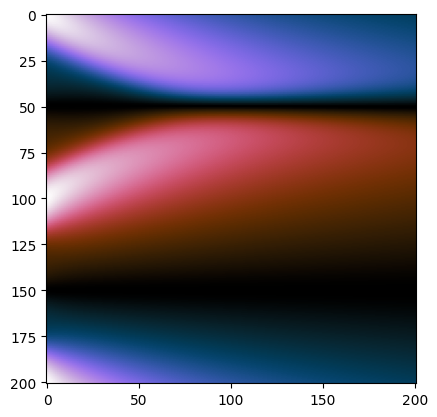

In [8]:
plt.imshow(u_i, cmap=cmr.emergency_s)

In [9]:
# Prepare data for training
U = u.type(torch.float32).to(device).requires_grad_()
V = v.type(torch.float32).to(device).requires_grad_()
times = t.type(torch.float32).to(device).requires_grad_()

In [10]:
# Declare neural networks

w = 400 # width of networks
N_x = 201 # input width

# Intrinsic dimension for manifold
intrinsic_dim = 6


class parameterization_NN(nn.Module):
    def __init__(self):
      super(parameterization_NN, self).__init__()
      self.hidden_U = nn.Linear(N_x,w, bias=True)
      self.hidden_V = nn.Linear(N_x,w, bias=True)
      self.hidden_H_1 = nn.Linear(N_x,w, bias=True); self.hidden_Z_1 = nn.Linear(w,w, bias=True)
      self.hidden_Z_2 = nn.Linear(w,w, bias=True)
      self.hidden_Z_3_mean_1 = nn.Linear(w,w, bias=True)
      self.hidden_Z_3_mean_2 = nn.Linear(w,intrinsic_dim, bias=True)
      self.hidden_Z_3_std_1 = nn.Linear(w,w, bias=True)
      self.hidden_Z_3_std_2 = nn.Linear(w,intrinsic_dim, bias=True)

    def forward(self, u):
      U = F.gelu(self.hidden_U(u)); V = F.gelu(self.hidden_V(u)); H_1 = F.gelu(self.hidden_H_1(u));
      Z_1 = F.gelu(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
      Z_2 = F.gelu(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
      output_mean_1 = F.gelu(self.hidden_Z_3_mean_1(H_3))
      output_mean_2 = self.hidden_Z_3_mean_2(output_mean_1)
      output_std_1 = F.gelu(self.hidden_Z_3_std_1(H_3))
      output_std_2 = self.hidden_Z_3_std_2(output_std_1)
      return output_mean_2, output_std_2

In [11]:
class g_NN(nn.Module):
    def __init__(self):
      super(g_NN, self).__init__()
      self.hidden_U = nn.Linear(intrinsic_dim+1,w, bias=True)
      self.hidden_V = nn.Linear(intrinsic_dim+1,w, bias=True)
      self.hidden_H_1 = nn.Linear(intrinsic_dim+1,w, bias=True); self.hidden_Z_1 = nn.Linear(w,w, bias=True)
      self.hidden_Z_2 = nn.Linear(w,w, bias=True); self.hidden_Z_3 = nn.Linear(w,intrinsic_dim*intrinsic_dim, bias=True)

    def forward(self, uv, tau):
      u = torch.cat((uv, tau),1)
      U = F.gelu(self.hidden_U(u)); V = F.gelu(self.hidden_V(u)); H_1 = F.gelu(self.hidden_H_1(u));
      Z_1 = F.gelu(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
      Z_2 = F.gelu(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
      Z_3 = self.hidden_Z_3(H_3)
      output_A = torch.reshape(Z_3, (u.size(dim=0),intrinsic_dim,intrinsic_dim))
      output = output = torch.bmm(torch.transpose(output_A, 1,2), output_A)
      return output

In [12]:
class Lambda_NN(nn.Module):
    def __init__(self):
      super(Lambda_NN, self).__init__()
      self.hidden_U = nn.Linear(intrinsic_dim + 1, w, bias=True)
      self.hidden_V = nn.Linear(intrinsic_dim + 1, w, bias=True)
      self.hidden_H_1 = nn.Linear(intrinsic_dim + 1, w, bias=True); self.hidden_Z_1 = nn.Linear(w,w, bias=True)
      self.hidden_Z_2 = nn.Linear(w,w, bias=True); self.hidden_Z_3 = nn.Linear(w,intrinsic_dim**2, bias=True)

    def forward(self, uv, tau):
      u = torch.cat((uv, tau),1)
      U = F.gelu(self.hidden_U(u)); V = F.gelu(self.hidden_V(u)); H_1 = F.gelu(self.hidden_H_1(u));
      Z_1 = F.gelu(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
      Z_2 = F.gelu(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
      Z_3 = self.hidden_Z_3(H_3)
      output_A = torch.reshape(Z_3, (u.size(dim=0),intrinsic_dim,intrinsic_dim))
      output = torch.bmm(torch.transpose(output_A, 1,2), output_A)
      return output

In [13]:
class encoder_NN(nn.Module):
    def __init__(self):
      super(encoder_NN, self).__init__()
      self.hidden_U = nn.Linear(intrinsic_dim+1,w, bias=True)
      self.hidden_V = nn.Linear(intrinsic_dim+1,w, bias=True)
      self.hidden_H_1 = nn.Linear(intrinsic_dim+1,w, bias=True); self.hidden_Z_1 = nn.Linear(w,w, bias=True)
      self.hidden_Z_2 = nn.Linear(w,w, bias=True); self.hidden_Z_3 = nn.Linear(w,intrinsic_dim+1, bias=True)

    # Our method works best with tanh activation here
    def forward(self, uv, tau):
      u = torch.cat((uv, tau),1)
      U = F.tanh(self.hidden_U(u)); V = F.tanh(self.hidden_V(u)); H_1 = F.tanh(self.hidden_H_1(u));
      Z_1 = F.tanh(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
      Z_2 = F.tanh(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
      Z_3 = self.hidden_Z_3(H_3)
      output = Z_3
      return output

In [14]:
class decoder_NN(nn.Module):
    def __init__(self):
      super(decoder_NN, self).__init__()
      self.hidden_U = nn.Linear(intrinsic_dim+1,w, bias=True)
      self.hidden_V = nn.Linear(intrinsic_dim+1,w, bias=True)
      self.hidden_H_1 = nn.Linear(intrinsic_dim+1,w, bias=True); self.hidden_Z_1 = nn.Linear(w,w, bias=True)
      self.hidden_Z_2 = nn.Linear(w,w, bias=True); self.hidden_Z_3 = nn.Linear(w,N_x, bias=True)

    # Our method works best with tanh activation here
    def forward(self, u):
      U = F.tanh(self.hidden_U(u)); V = F.tanh(self.hidden_V(u)); H_1 = F.tanh(self.hidden_H_1(u));
      Z_1 = F.tanh(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
      Z_2 = F.tanh(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
      Z_3 = self.hidden_Z_3(H_3)
      output = Z_3
      return output

In [26]:
# Declare networks
parameterization = parameterization_NN().to(device)
g = g_NN().to(device)
Lambda = Lambda_NN().to(device)
encoder = encoder_NN().to(device)
decoder = decoder_NN().to(device)

In [27]:
# Create optimizer
optimizer = optim.Adam([
    {'params': parameterization.parameters()},
    {'params': g.parameters()},
    {'params': Lambda.parameters()},
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
], lr=2e-4)#, weight_decay=1e-4)

In [45]:
# Load in pre-trained neural networks from current directory

File = "parameterization.pth"
parameterization.load_state_dict(torch.load(File))

File = "encoder.pth"
encoder.load_state_dict(torch.load(File))

File = "decoder.pth"
decoder.load_state_dict(torch.load(File))

File = "g.pth"
g.load_state_dict(torch.load(File))

File = "Lambda.pth"
Lambda.load_state_dict(torch.load(File))

<ipython-input-45-05fa5978c546>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameterization.load_state_dict(torch.load(File))
<ipython-input-45-05fa5978c546>:7: Future

<All keys matched successfully>

In [18]:
# Create function to get metric coefficients of the encoder neural network (not g)

def metric_of_encoder(encoder, uv, tau, intrinsic_dim, N):

  # Get tangent vectors
  encoder_uv = torch.zeros(size=(N,intrinsic_dim+1,intrinsic_dim)).to(device)
  encoded_rep = encoder(uv, tau)
  for col in range(encoder_uv.size(dim=1)):
    encoder_uv[:,col,:] = torch.autograd.grad(encoded_rep[:,col].sum(), uv, create_graph=True)[0]

  encoder_metric = torch.zeros(size=(N,intrinsic_dim,intrinsic_dim)).to(device)

  # Compute metric coefficient inner products with the encoder
  for i in range(intrinsic_dim):
    for j in range(i+1):
      encoder_metric[:,i,j] = torch.sum( torch.squeeze(encoder_uv[:,:,i]) * torch.squeeze(encoder_uv[:,:,j]), dim=1)
      encoder_metric[:,j,i] = encoder_metric[:,i,j]

  return encoder_metric

In [19]:
# Reparameterization trick

def get_reparameterization_sample(parameterization, U, intrinsic_dim, N):

  # Sample the parameterization
  means_eval, stds_eval = parameterization(U)

  random_normal = torch.normal(0,1,size=(N,intrinsic_dim), requires_grad=True).to(device)

  uv_sample = means_eval  +   stds_eval * random_normal

  return uv_sample

In [20]:
# Create loss function between the metric neural network and the computed metric with the encoder

def loss_metric_func(g, encoder, uv, tau, intrinsic_dim, N):

  # Compute g neural network output
  g_rep = g(uv, tau)

  # Compute matrix inner product
  # < partial_j E (u_i), partial_k E (u_i) >
  inner_product_matrix = metric_of_encoder(encoder, uv, tau, intrinsic_dim, N)

  # Compute difference matrix
  diff =  g_rep  - inner_product_matrix

  # Return loss, which is a scaled matrix norm
  loss = (1/torch.numel(diff))*torch.norm(diff)**2
  return loss

In [22]:
# Geometric flow physics-informed loss

def loss_geo_flow_func(g, Lambda, uv, tau, intrinsic_dim, N):

  # Get g, Lambda
  G = g(uv, tau)
  Lambda_eval = Lambda(uv, tau)

  identity_mat = torch.eye(intrinsic_dim).expand(N, -1, -1).to(device)

  # Compute metric of sphere for regularization of the flow
  sin_uv = torch.sin(uv)
  spherical_matrix = torch.zeros(size=(N,intrinsic_dim,intrinsic_dim)).to(device)
  spherical_matrix[:,0,0] = 10
  for i in range(1,intrinsic_dim):
    spherical_matrix[:,i,i] = 10 * torch.prod(sin_uv[:,0:i]**2, dim=1)



  # Compute time derivative of each metric coefficient
  g_t = torch.zeros(size=(N,intrinsic_dim,intrinsic_dim)).to(device)
  for row in range(intrinsic_dim):
    for col in range(row+1):
      g_t[:,row,col] = torch.autograd.grad(G[:,row,col].sum(), tau, create_graph=True)[0][:,0]
      g_t[:,col,row] = g_t[:,row,col]


  # Eigenvalue penalization
  diff = G - spherical_matrix
  diff_eigen = torch.linalg.eigvalsh(diff)
  penalty = F.relu(-diff_eigen)

  # Physics-informed loss
  geo_flow_loss = g_t +  torch.bmm( Lambda_eval , G )    +  2 * (G - spherical_matrix)


  loss = (1/torch.numel(geo_flow_loss)) * torch.norm(geo_flow_loss)**2    + (1/torch.numel(penalty))* torch.norm(penalty)**2

  return(loss)

In [23]:
# Decoded (log-likelihood) loss

def loss_decoded_func(U, V, uv, tau, encoder, decoder, parameterization, N):

  # Pass data into neural networks
  uv = get_reparameterization_sample(parameterization, U, intrinsic_dim, N)
  encoded_rep = encoder(uv, tau)
  decoded_rep = decoder(encoded_rep)

  diff = decoded_rep - V

  # Compute log-likelihood
  loss = (1/torch.numel(diff)) * torch.norm(diff)**2

  return loss

In [24]:
# KL regularization in the parameterization

def loss_kl_func(parameterization, U, N):

  means_eval, stds_eval = parameterization(U)
  epsilon = 1e-18 # Small regularization constant

  kl_loss =  -torch.sum(1 + torch.log(stds_eval**2 + epsilon) - means_eval**2 - stds_eval**2, dim=1)

  return torch.mean(kl_loss)

In [30]:
# Training algorithm

num_iterations = 100 # Take arbitrarily high; modify as necessary
batch_size = 1000




for num in range(num_iterations):


  I = np.random.randint(0,int(num_samples*N_x),batch_size)

  # Sample parameterization and time
  uv = get_reparameterization_sample(parameterization, U[I,:], intrinsic_dim, batch_size)
  tau = times[I,:]

  # Compute all individual loss terms
  loss_metric = loss_metric_func(g, encoder, uv, tau, intrinsic_dim, batch_size)
  loss_geo_flow = loss_geo_flow_func(g, Lambda, uv, tau, intrinsic_dim, batch_size)
  loss_decoded = loss_decoded_func(U[I,:], V[I,:], uv, tau, encoder, decoder, parameterization, batch_size)
  loss_kl = loss_kl_func(parameterization, U[I,:], batch_size)


  # Total objective; scale coefficients as necessary
  loss =  100*loss_decoded + 0.0001*loss_kl +  1*loss_metric + 1*loss_geo_flow


  optimizer.zero_grad()
  loss.backward()

  # Gradient clipping; helps training
  torch.nn.utils.clip_grad_value_(parameterization.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(g.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(encoder.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(decoder.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(Lambda.parameters(), 1.)

  optimizer.step()


  if num % 20 == 0:
    print("Training loss:", '{:.4e}'.format(loss.data), \
          "Metric:", '{:.4e}'.format(loss_metric.data), \
          "Geo flow:", '{:.4e}'.format(loss_geo_flow.data),
          "Decoded:", '{:.4e}'.format(loss_decoded.data), \
          "KL:", '{:.4e}'.format(loss_kl.data))


Training loss: 2.2184e-01 Metric: 2.0754e-02 Geo flow: 6.2811e-02 Decoded: 1.3298e-03 KL: 5.2868e+01
Training loss: 5.9568e-02 Metric: 6.1144e-03 Geo flow: 8.4853e-03 Decoded: 3.9510e-04 KL: 5.4580e+01
Training loss: 3.2590e-02 Metric: 3.0908e-03 Geo flow: 3.4183e-03 Decoded: 2.0724e-04 KL: 5.3569e+01
Training loss: 2.7782e-02 Metric: 2.6178e-03 Geo flow: 2.1069e-03 Decoded: 1.7690e-04 KL: 5.3673e+01
Training loss: 2.1491e-02 Metric: 2.1389e-03 Geo flow: 1.6602e-03 Decoded: 1.2054e-04 KL: 5.6380e+01


In [ ]:
# Save newly-trained neural networks to current directory

File = "parameterization.pth"
torch.save(parameterization.state_dict(), File)

File = "encoder.pth"
torch.save(encoder.state_dict(), File)

File = "decoder.pth"
torch.save(decoder.state_dict(), File)

File = "g.pth"
torch.save(g.state_dict(), File)

File = "Lambda.pth"
torch.save(Lambda.state_dict(), File)

In [39]:
# Visualization function

def heatmap2d(u):

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  im = ax.imshow(u[:,:], cmap=cmr.emergency_s_r)

  ax.set_xticks([0,100,200], ['0', ' 0.5', '1'])
  ax.set_yticks([0,100,200], ['0', ' 0.5', '1'])
  ax.grid(False)

  fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.3, hspace=0.3)

  cb_ax = fig.add_axes([0.83, 0.15, 0.04, 0.7])
  cbar = fig.colorbar(im, cax=cb_ax)

  plt.savefig('Burgers_test.png', dpi=700)
  plt.show()

In [34]:
# Get test results

np.random.seed(6)

# Get random PDE sample
uu_test = torch.zeros(size=(1,N_x,N_t)).to(device)
alpha = np.random.uniform(-1,1,3)
u0 = alpha[0]*np.cos(2*math.pi*X) + alpha[1]*(np.cos(2*math.pi*X))**3 + alpha[2]*(np.cos(2*math.pi*X))**5
u_i_test = odeint(burg_system, u0, T, args=(k,), mxstep=5000).T
uu_test[0,:,:] = torch.from_numpy(u_i_test).to(device)


# Add noise if desired for robustness test
uu_test_noise = uu_test.clone()
noise = np.random.normal(0,0.65, size=(201))
noise[np.random.choice(201,100, replace=False)] = 0
uu_test_noise[0,:,0] = 1.15*uu_test[0,:,0] + torch.from_numpy(noise).to(device) # Scale if desired

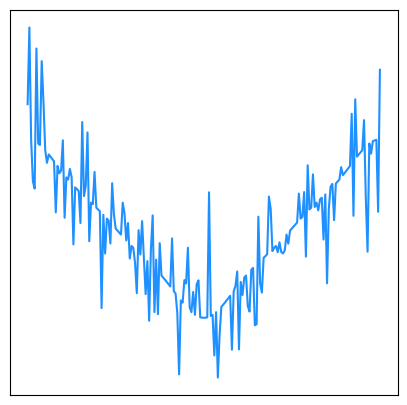

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(uu_test_noise[:,:,0].cpu().detach().numpy().squeeze(), color='dodgerblue')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('Burgers_observed.png', dpi=700)

In [37]:
# Get 2D solution to test data

decoded_2d = torch.zeros(size=(N_x,N_t))

for num in range(N_t):
  t_test = (num/(N_t))*torch.ones(size=(1,1)).to(device)
  t_index = int(t_test*100)

  means_eval, stds_eval = parameterization(uu_test_noise[0,:,0])
  random_normal = torch.normal(0,1,size=(1,intrinsic_dim), requires_grad=True).to(device)
  uv_sample = means_eval

  encoded_rep = encoder(uv_sample.unsqueeze(0), t_test)
  decoded_rep = decoder(encoded_rep)

  decoded_2d[:,num] = decoded_rep

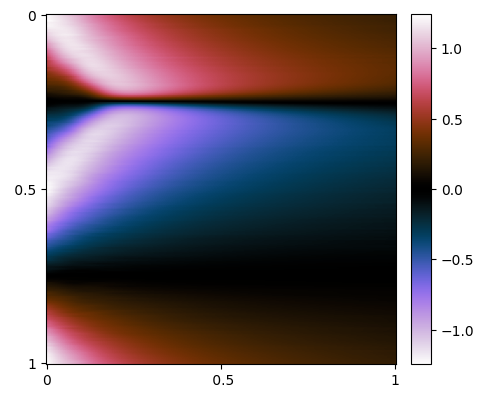

In [40]:
# View robustness solution
heatmap2d(decoded_2d.cpu().detach().numpy())

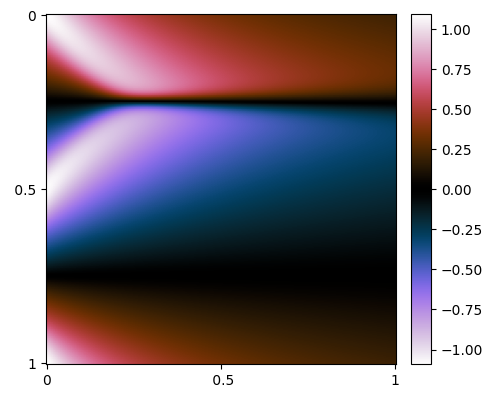

In [41]:
# Reference data
heatmap2d(uu_test[0,:,:].cpu().detach().numpy())

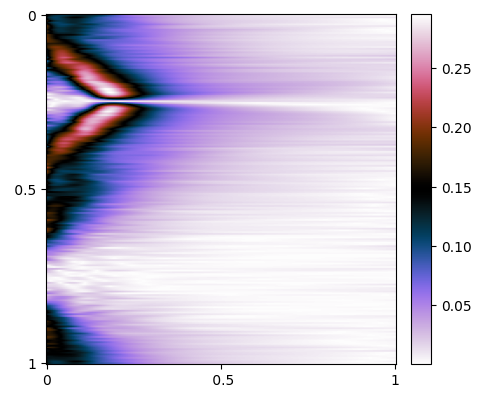

In [42]:
# Display error
heatmap2d( np.abs( decoded_2d.cpu().detach().numpy() - uu_test[0,:,:].cpu().detach().numpy() ) )

In [48]:
# Get error results over numerous test data

num_errors = 30 # Number of test samples
errors = np.zeros(shape=(num_errors,1))

np.random.seed(7)

for num_sample in range(num_errors):


  # Use new data if desired; takes longer

  #alpha = np.random.uniform(-1,1,3)
  #beta = np.random.uniform(0.8,1.2,3)
  #u0 = alpha[0]*np.cos(beta[0]*2*math.pi*X) + alpha[1]*(np.cos(beta[1]*2*math.pi*X))**3 + alpha[2]*(beta[2]*np.cos(2*math.pi*X))**5
  #u_i = odeint(burg_system, u0, T, args=(k,), mxstep=5000).T
  #uu_test[0,:,:] = torch.from_numpy(u_i)


  # Use training data if desired

  rand_i = np.random.randint(800,1000,1).squeeze()
  uu_test = torch.zeros(size=(1,201,201)).to(device)
  uu_test[0,:,:] = torch.from_numpy(Burgers_data_np[rand_i,:,:]).to(device)


  uu_test_noise = torch.zeros(size=(1,N_x,N_t)).to(device)
  uu_test_noise = uu_test.clone()
  noise = np.random.normal(0,1.0, size=(201))
  noise[np.random.choice(201,150, replace=False)] = 0
  uu_test_noise[:,:,0] = 1.0*uu_test[:,:,0]   + torch.from_numpy(noise).to(device)


  decoded_2d = torch.zeros(size=(N_x,1))



  # Choose sample time for evaluation
  time = 0.5
  num = int(time*200)   #int(50*2)
  t_test = T[num]*torch.ones(size=(1,1)).to(device)
  t_index = num

  means_eval, stds_eval = parameterization(uu_test_noise[:,:,0].unsqueeze(0))
  random_normal = torch.normal(0,1,size=(1,intrinsic_dim), requires_grad=True).to(device)
  uv_sample = means_eval


  encoded_rep = encoder(uv_sample.squeeze().unsqueeze(0), t_test)
  decoded_rep = decoder(encoded_rep)

  decoded_2d[:,0] = decoded_rep


  errors[num_sample,0] =  np.sum(np.abs(decoded_2d.cpu().detach().numpy().squeeze()  - uu_test[0,:,num].cpu().detach().numpy() ) ) \
                          / np.sum(np.abs(uu_test[0,:,num].cpu().detach().numpy()))

In [49]:
# Get test errors over number of samples
print(np.mean(errors[:,0]))
print(np.std(errors[:,0]))

0.16304720425978303
0.2420896937978161
